Using ULM fit for doing text classification on the coling classification data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from fastai.text.data import TextDataBunch, TextLMDataBunch
from fastai.text import language_model_learner
from fastai.text.models.awd_lstm import AWD_LSTM
import pandas as pd

In [28]:
data_path = "/home/thiago/code/tgalery/geiger/datasets/coling/english/"

In [29]:
df_train = pd.read_csv(data_path + 'agr_en_train.csv', header=None)
df_train.head()

,0,1,2
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [10]:
df_train[1][1] 

"Most of Private Banks ATM's Like HDFC, ICICI etc are out of cash. Only Public sector bank's ATM working"

In [15]:
df_dev = pd.read_csv(data_path + 'agr_en_dev.csv', header=None)
df_dev.head()

,0,1,2
0,facebook_corpus_msr_451811,The quality of re made now makes me think it i...,CAG
1,facebook_corpus_msr_334368,@siva \nHow is ur mother???\nHow is ur wife???...,NAG
2,facebook_corpus_msr_331195,Also see ....hw ur RSS activist caught in Burk...,NAG
3,facebook_corpus_msr_403402,On the death of 2 jawans in LOC CROSS FIRING\n...,NAG
4,facebook_corpus_msr_379239,Modi ho ya Manmohan singh saala yeh log kuch n...,OAG


In [16]:
df_dev[1][1] 

'@siva \nHow is ur mother???\nHow is ur wife???\nHow is ur sister???\n\nHope everyone is fine....😁😁😁'

In [30]:
data_lm = TextLMDataBunch.from_df(data_path, df_train, df_dev, label_cols=2)

In [31]:
data_lm.save()

In [32]:
data_lm.show_batch()

idx,text
0,"muslims who does not know the meaning of unity and xxunk their thoughts on others xxrep 5 . all the rascals have gathered there ... xxbos ? ? we r against cow slaughter , so of course it will stop leather manufacturing if it happens . xxbos xxmaj wondering why xxmaj educated xxmaj ambassador is struggling to pay through xxmaj credit / xxmaj debit at a xxmaj decent xxmaj restaurant"
1,"you ca n't xxunk between a military activity and an act of barbarism . \n \n xxmaj remember the xxup nli , bodies of whose soldiers you refused to acknowledge during kargil conflict . \n \n xxmaj so , keep your knowledge to yourself and live in your own fantasy land . xxbos xxmaj cows are definitely gon na vote for xxmaj modi ji in 2019 ;) xxbos"
2,lifetime xxbos xxmaj this is despicable n only a pervert will do dis n d pakis r perverts . xxbos @ xxmaj neel xxmaj patel ... xxmaj glad to know dat ur xxunk ppl still exists ... xxmaj stay blessed xxbos xxmaj president xxmaj xi xxmaj xxunk has xxunk advancing xxmaj china 's space programme to strengthen national security . xxbos xxup bjp running xxup mcd for ten years .
3,legal opinion issued only by a qualified jurist ( xxmaj mufti ) on a request by someone who is unable to understand religious guidelines whereas the leaflet that is being circulated and presented as xxmaj fatwa is just a hard copy of an appeal signed by 46 men who believe in religious practices . xxmaj the merit of appeal can be discussed on many grounds and in many dimensions but
4,are paying you xxunk boss is not paying you . \n xxmaj do n't think of excelling your self .as you said economic survey of xxmaj india .the key figure is xxmaj india & not xxup fm . \n \n xxmaj note xxmaj ban has ruined all sectors xxunk was result of keeping boss happy . \n \n xxmaj note ban killed so many .but soldiers save


Now that we have a data buch created, we can download a pre-trained language model and train some more.

In [33]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Let's find a learning rate and start fine tunning the model

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


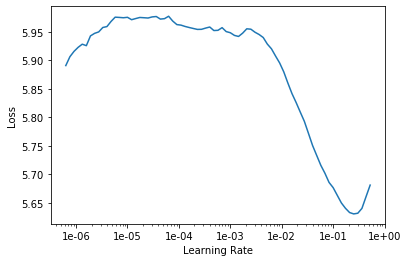

In [35]:
learn.recorder.plot(skip_end=15)

In [36]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.846286,4.500495,0.247078,06:21


In [37]:
learn.save('fit_head')

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.269690,4.297551,0.268375,09:25
1,4.033995,4.181139,0.280895,08:26
2,3.670890,4.150775,0.287439,08:26
3,3.407171,4.175678,0.286840,08:46


In [40]:
learn.save('fine_tuned')

In [48]:
TEXT = "We should fire stathis because, "
N_WORDS = 40
N_SENTENCES = 2

In [49]:
for _ in range(N_SENTENCES):
    print(learn.predict(TEXT, N_WORDS, temperature=0.75) + "\n\n")

We should fire stathis because,  when there comes a fire . We have Fire Department , and Fire Station , Fire Station Door Range . xxbos All you people are coming out of our country


We should fire stathis because,  as the terrorist attacks spread , we can save our own people and unite our jawans to take revenge . 
  This video has to be done by Tata Group to stop it from using Tata




In [50]:
learn.save_encoder('fine_tuned_enc')